In [1]:
# Tool
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")

print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query wikipedia articles")

print(wiki.name)

wikipedia


In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [6]:
# Tavily Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [7]:
# tavily.invoke("Give recent news on AI")

In [8]:
# Combining all tools

tools = [arxiv, wiki, tavily]

In [14]:
# Init LLM
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

In [ ]:
# llm.invoke("what is ai")

AIMessage(content='<think>\nOkay, the user is asking, "what is ai." Let me start by breaking down the question. They might be a beginner with no prior knowledge, so I need to explain AI in simple terms. First, I should define AI as a branch of computer science focused on creating systems that can perform tasks requiring human intelligence.\n\nI should mention the key areas AI deals with, like learning from data, problem-solving, perception, and language understanding. Maybe give examples of AI applications they might be familiar with, like virtual assistants, recommendation systems, or self-driving cars. That helps make the concept relatable.\n\nI need to differentiate between narrow AI, which is what we have now and is specialized, and the hypothetical general AI that doesn\'t exist yet. It\'s important to clarify that current AI isn\'t sentient or conscious, just really good at specific tasks.\n\nAlso, touch on how AI works—machine learning, neural networks, and data. Maybe explain t

In [16]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
# Execute call

llm_with_tools.invoke("recent news on ai") # Returns reasoning 

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. Let me see which tool I should use here. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best fit for recent news. Wikipedia might have some information, but it\'s more of an encyclopedia and might not have the latest updates. The third option is tavily_search_results_json, which is described as a search engine optimized for comprehensive, accurate, and trusted results, especially for current events. That sounds perfect for this query.\n\nSo I should use tavily_search_results_json with the query "recent news on ai". The parameters require a "query" string, which I have. Just need to structure the tool call correctly. Let me make sure the JSON is formatted right with the function name and arguments.\n', 'tool_calls': [{'id': '60560brfr', 'function': {'arguments': '{"query":"recent news on ai"}', 'name'

## LangGraph Application

#### Workflow

In [22]:
# State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # Human or AI message
from typing import Annotated
from langgraph.graph.message import add_messages # Reducers - Append not overwrite

In [24]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # List of all AI, system, human messages

In [25]:
# Chatbot with LangGraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

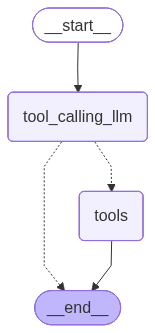

In [39]:
# Node definition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition) # routes to tool or end depending on latest message
builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages = graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (zm1zz5zwm)
 Call ID: zm1zz5zwm
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [33]:
messages = graph.invoke({"messages":"hello"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?


### ReAct

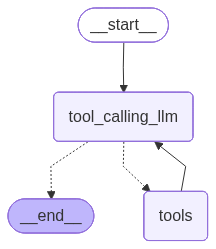

In [42]:
# Node definition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition) # routes to tool or end depending on latest message
builder.add_edge("tools",END)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
messages = graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (2vve4atke)
 Call ID: 2vve4atke
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================

The arXiv paper **1706.03762** corresponds to the seminal work **"A

In [45]:
messages = graph.invoke({"messages":"What is some recent news on agentic ai and give me some recent papers on it"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is some recent news on agentic ai and give me some recent papers on it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tttfhxasz)
 Call ID: tttfhxasz
  Args:
    query: recent news on agentic AI 2024
  arxiv (a16xvwvgt)
 Call ID: a16xvwvgt
  Args:
    query: autonomous AI agents 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 10 Large Agentic Model Tools to Watch in 2024 for Enhanced ...", "url": "https://superagi.com/top-10-large-agentic-model-tools-to-watch-in-2024-for-enhanced-business-efficiency/", "content": "explored the introduction to agentic AI, its key components and methodologies, autonomy and decision-making, real-world applications, and the top 10 tools to watch in 2024.  According to recent research, agentic AI represents a si